In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import callbacks
import os
import cv2
import string
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

#Init main values
# symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
symbols = "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (62, 175, 1)

In [2]:
print(num_symbols)

10


In [3]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    #we have 6 letters
    for _ in range(6):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

Importing Data

In [4]:
def preprocess_data():
    n_samples = len(os.listdir('data/wetax'))
    X = np.zeros((n_samples, 62, 175, 1)) #1070*62*175
    y = np.zeros((6, n_samples, num_symbols)) #6*1070*10

    for i, pic in enumerate(os.listdir('data/wetax')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('data/wetax', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 7:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (62, 175, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((6, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]
print(str(len(X_train)) + " training samples")
print(str(len(X_test)) + " validation samples")


970 training samples
134 validation samples


In [5]:
model=create_model();
model.summary();

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 62, 175, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 175, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 31, 88, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 31, 88, 32)   4640        max_pooling2d[0][0]              
_______________________________________________________________________________________

In [12]:
#model = create_model()
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4], y_train[5]], batch_size=32, epochs=100,verbose=1, validation_split=0.2)

Epoch 1/100
25/25 [==============================] - 1s 29ms/step - loss: 0.2453 - dense_1_loss: 0.0125 - dense_3_loss: 0.0303 - dense_5_loss: 0.0337 - dense_7_loss: 0.0401 - dense_9_loss: 0.0548 - dense_11_loss: 0.0739 - dense_1_accuracy: 0.9948 - dense_3_accuracy: 0.9884 - dense_5_accuracy: 0.9871 - dense_7_accuracy: 0.9820 - dense_9_accuracy: 0.9768 - dense_11_accuracy: 0.9755 - val_loss: 14.9174 - val_dense_1_loss: 14.0910 - val_dense_3_loss: 0.0833 - val_dense_5_loss: 0.0086 - val_dense_7_loss: 0.2602 - val_dense_9_loss: 0.4076 - val_dense_11_loss: 0.0668 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9588 - val_dense_9_accuracy: 0.9330 - val_dense_11_accuracy: 0.9897
Epoch 2/100
25/25 [==============================] - 1s 27ms/step - loss: 0.2300 - dense_1_loss: 0.0033 - dense_3_loss: 0.0223 - dense_5_loss: 0.0472 - dense_7_loss: 0.0522 - dense_9_loss: 0.0690 - dense_11_loss: 0.0359 - dense_1_accuracy: 1.0000

Epoch 12/100
25/25 [==============================] - 1s 26ms/step - loss: 0.1571 - dense_1_loss: 0.0036 - dense_3_loss: 0.0192 - dense_5_loss: 0.0280 - dense_7_loss: 0.0336 - dense_9_loss: 0.0374 - dense_11_loss: 0.0353 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9923 - dense_5_accuracy: 0.9910 - dense_7_accuracy: 0.9820 - dense_9_accuracy: 0.9871 - dense_11_accuracy: 0.9871 - val_loss: 15.6870 - val_dense_1_loss: 14.7613 - val_dense_3_loss: 0.0835 - val_dense_5_loss: 0.0013 - val_dense_7_loss: 0.2709 - val_dense_9_loss: 0.4506 - val_dense_11_loss: 0.1194 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9536 - val_dense_9_accuracy: 0.9381 - val_dense_11_accuracy: 0.9794
Epoch 13/100
25/25 [==============================] - 1s 27ms/step - loss: 0.2044 - dense_1_loss: 0.0205 - dense_3_loss: 0.0274 - dense_5_loss: 0.0277 - dense_7_loss: 0.0470 - dense_9_loss: 0.0580 - dense_11_loss: 0.0237 - dense_1_accuracy: 0.99

Epoch 23/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1758 - dense_1_loss: 0.0177 - dense_3_loss: 0.0206 - dense_5_loss: 0.0292 - dense_7_loss: 0.0414 - dense_9_loss: 0.0398 - dense_11_loss: 0.0272 - dense_1_accuracy: 0.9936 - dense_3_accuracy: 0.9936 - dense_5_accuracy: 0.9910 - dense_7_accuracy: 0.9871 - dense_9_accuracy: 0.9871 - dense_11_accuracy: 0.9910 - val_loss: 15.6092 - val_dense_1_loss: 14.6520 - val_dense_3_loss: 0.0831 - val_dense_5_loss: 0.0065 - val_dense_7_loss: 0.3009 - val_dense_9_loss: 0.5037 - val_dense_11_loss: 0.0630 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9330 - val_dense_11_accuracy: 0.9845
Epoch 24/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1663 - dense_1_loss: 0.0037 - dense_3_loss: 0.0140 - dense_5_loss: 0.0371 - dense_7_loss: 0.0431 - dense_9_loss: 0.0436 - dense_11_loss: 0.0249 - dense_1_accuracy: 0.99

Epoch 34/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1561 - dense_1_loss: 0.0040 - dense_3_loss: 0.0407 - dense_5_loss: 0.0243 - dense_7_loss: 0.0219 - dense_9_loss: 0.0347 - dense_11_loss: 0.0305 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9871 - dense_5_accuracy: 0.9845 - dense_7_accuracy: 0.9910 - dense_9_accuracy: 0.9820 - dense_11_accuracy: 0.9884 - val_loss: 15.4332 - val_dense_1_loss: 14.4894 - val_dense_3_loss: 0.0831 - val_dense_5_loss: 0.0055 - val_dense_7_loss: 0.2196 - val_dense_9_loss: 0.5642 - val_dense_11_loss: 0.0713 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9794
Epoch 35/100
25/25 [==============================] - 1s 26ms/step - loss: 0.1791 - dense_1_loss: 0.0022 - dense_3_loss: 0.0173 - dense_5_loss: 0.0374 - dense_7_loss: 0.0361 - dense_9_loss: 0.0532 - dense_11_loss: 0.0330 - dense_1_accuracy: 1.00

25/25 [==============================] - 1s 26ms/step - loss: 0.2329 - dense_1_loss: 0.0069 - dense_3_loss: 0.0196 - dense_5_loss: 0.0461 - dense_7_loss: 0.0490 - dense_9_loss: 0.0596 - dense_11_loss: 0.0516 - dense_1_accuracy: 0.9974 - dense_3_accuracy: 0.9948 - dense_5_accuracy: 0.9884 - dense_7_accuracy: 0.9820 - dense_9_accuracy: 0.9858 - dense_11_accuracy: 0.9781 - val_loss: 16.0899 - val_dense_1_loss: 14.8520 - val_dense_3_loss: 0.0842 - val_dense_5_loss: 0.0121 - val_dense_7_loss: 0.3432 - val_dense_9_loss: 0.6259 - val_dense_11_loss: 0.1725 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9381 - val_dense_9_accuracy: 0.9278 - val_dense_11_accuracy: 0.9794
Epoch 45/100
25/25 [==============================] - 1s 26ms/step - loss: 0.2289 - dense_1_loss: 0.0034 - dense_3_loss: 0.0159 - dense_5_loss: 0.0563 - dense_7_loss: 0.0549 - dense_9_loss: 0.0396 - dense_11_loss: 0.0588 - dense_1_accuracy: 1.0000 - dense_3_

Epoch 55/100
25/25 [==============================] - 1s 26ms/step - loss: 0.1290 - dense_1_loss: 0.0036 - dense_3_loss: 0.0185 - dense_5_loss: 0.0282 - dense_7_loss: 0.0234 - dense_9_loss: 0.0258 - dense_11_loss: 0.0295 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9936 - dense_5_accuracy: 0.9923 - dense_7_accuracy: 0.9948 - dense_9_accuracy: 0.9871 - dense_11_accuracy: 0.9897 - val_loss: 15.8251 - val_dense_1_loss: 14.8150 - val_dense_3_loss: 0.0831 - val_dense_5_loss: 7.2905e-04 - val_dense_7_loss: 0.3215 - val_dense_9_loss: 0.5188 - val_dense_11_loss: 0.0859 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9639 - val_dense_9_accuracy: 0.9485 - val_dense_11_accuracy: 0.9897
Epoch 56/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1506 - dense_1_loss: 0.0025 - dense_3_loss: 0.0194 - dense_5_loss: 0.0329 - dense_7_loss: 0.0272 - dense_9_loss: 0.0377 - dense_11_loss: 0.0308 - dense_1_accuracy: 

Epoch 66/100
25/25 [==============================] - 1s 27ms/step - loss: 0.1078 - dense_1_loss: 0.0051 - dense_3_loss: 0.0145 - dense_5_loss: 0.0131 - dense_7_loss: 0.0214 - dense_9_loss: 0.0336 - dense_11_loss: 0.0202 - dense_1_accuracy: 0.9987 - dense_3_accuracy: 0.9936 - dense_5_accuracy: 0.9936 - dense_7_accuracy: 0.9936 - dense_9_accuracy: 0.9871 - dense_11_accuracy: 0.9910 - val_loss: 15.8709 - val_dense_1_loss: 14.8445 - val_dense_3_loss: 0.0898 - val_dense_5_loss: 9.7067e-04 - val_dense_7_loss: 0.3568 - val_dense_9_loss: 0.4795 - val_dense_11_loss: 0.0993 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9897 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9588 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9845
Epoch 67/100
25/25 [==============================] - 1s 26ms/step - loss: 0.1654 - dense_1_loss: 0.0022 - dense_3_loss: 0.0229 - dense_5_loss: 0.0183 - dense_7_loss: 0.0491 - dense_9_loss: 0.0390 - dense_11_loss: 0.0338 - dense_1_accuracy: 

Epoch 77/100
25/25 [==============================] - 1s 26ms/step - loss: 0.1298 - dense_1_loss: 0.0044 - dense_3_loss: 0.0165 - dense_5_loss: 0.0300 - dense_7_loss: 0.0221 - dense_9_loss: 0.0273 - dense_11_loss: 0.0296 - dense_1_accuracy: 0.9987 - dense_3_accuracy: 0.9936 - dense_5_accuracy: 0.9884 - dense_7_accuracy: 0.9910 - dense_9_accuracy: 0.9858 - dense_11_accuracy: 0.9845 - val_loss: 15.8501 - val_dense_1_loss: 14.8457 - val_dense_3_loss: 0.0862 - val_dense_5_loss: 1.2202e-05 - val_dense_7_loss: 0.3403 - val_dense_9_loss: 0.4574 - val_dense_11_loss: 0.1206 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9485 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9897
Epoch 78/100
25/25 [==============================] - 1s 26ms/step - loss: 0.1364 - dense_1_loss: 0.0034 - dense_3_loss: 0.0234 - dense_5_loss: 0.0194 - dense_7_loss: 0.0316 - dense_9_loss: 0.0370 - dense_11_loss: 0.0216 - dense_1_accuracy: 

Epoch 88/100
25/25 [==============================] - 1s 29ms/step - loss: 0.1067 - dense_1_loss: 0.0021 - dense_3_loss: 0.0094 - dense_5_loss: 0.0142 - dense_7_loss: 0.0186 - dense_9_loss: 0.0322 - dense_11_loss: 0.0303 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9961 - dense_5_accuracy: 0.9936 - dense_7_accuracy: 0.9923 - dense_9_accuracy: 0.9832 - dense_11_accuracy: 0.9884 - val_loss: 15.6652 - val_dense_1_loss: 14.8547 - val_dense_3_loss: 0.0832 - val_dense_5_loss: 2.5847e-05 - val_dense_7_loss: 0.2199 - val_dense_9_loss: 0.4333 - val_dense_11_loss: 0.0741 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9330 - val_dense_11_accuracy: 0.9845
Epoch 89/100
25/25 [==============================] - 1s 29ms/step - loss: 0.1646 - dense_1_loss: 0.0095 - dense_3_loss: 0.0242 - dense_5_loss: 0.0235 - dense_7_loss: 0.0340 - dense_9_loss: 0.0391 - dense_11_loss: 0.0343 - dense_1_accuracy: 

Epoch 99/100
25/25 [==============================] - 1s 30ms/step - loss: 0.1182 - dense_1_loss: 0.0241 - dense_3_loss: 0.0169 - dense_5_loss: 0.0228 - dense_7_loss: 0.0190 - dense_9_loss: 0.0236 - dense_11_loss: 0.0118 - dense_1_accuracy: 0.9961 - dense_3_accuracy: 0.9936 - dense_5_accuracy: 0.9910 - dense_7_accuracy: 0.9936 - dense_9_accuracy: 0.9897 - dense_11_accuracy: 0.9948 - val_loss: 15.7605 - val_dense_1_loss: 14.7822 - val_dense_3_loss: 0.0831 - val_dense_5_loss: 5.4408e-06 - val_dense_7_loss: 0.2461 - val_dense_9_loss: 0.5597 - val_dense_11_loss: 0.0894 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9742 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9897
Epoch 100/100
25/25 [==============================] - 1s 30ms/step - loss: 0.1214 - dense_1_loss: 0.0046 - dense_3_loss: 0.0227 - dense_5_loss: 0.0185 - dense_7_loss: 0.0328 - dense_9_loss: 0.0163 - dense_11_loss: 0.0265 - dense_1_accuracy:

In [13]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (6, 10))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5


In [14]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5]],verbose=1)
print('='*100)
print('Test Loss and accuracy:', score)

5/5 [==============================] - 0s 9ms/step - loss: 16.6693 - dense_1_loss: 15.5198 - dense_3_loss: 2.3484e-05 - dense_5_loss: 0.1203 - dense_7_loss: 0.3791 - dense_9_loss: 0.3349 - dense_11_loss: 0.3152 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 0.9925 - dense_7_accuracy: 0.9478 - dense_9_accuracy: 0.9627 - dense_11_accuracy: 0.9776    
Test Loss and accuracy: [16.669261932373047, 15.519804954528809, 2.3483778932131827e-05, 0.12028636038303375, 0.3790777027606964, 0.33487430214881897, 0.3151951730251312, 0.0, 1.0, 0.9925373196601868, 0.9477611780166626, 0.9626865386962891, 0.9776119589805603]


In [15]:
# Check model on some samples
model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5]])
print('='*100)
print(predict('data/test/wetax/028885.png'))
print(predict('data/test/wetax/049858.png'))
print(predict('data/test/wetax/339524.png'))
print(predict('data/test/wetax/366405.png'))
print(predict('data/test/wetax/400567.png'))

5/5 [==============================] - 0s 9ms/step - loss: 16.6693 - dense_1_loss: 15.5198 - dense_3_loss: 2.3484e-05 - dense_5_loss: 0.1203 - dense_7_loss: 0.3791 - dense_9_loss: 0.3349 - dense_11_loss: 0.3152 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 0.9925 - dense_7_accuracy: 0.9478 - dense_9_accuracy: 0.9627 - dense_11_accuracy: 0.9776    
028885
049858
339524
366405
400567


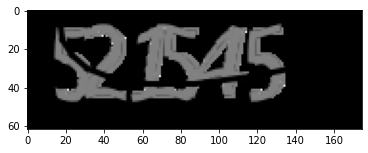

In [10]:
#Lets test an unknown captcha
#preview
%matplotlib inline 
import matplotlib.pyplot as plt
img=cv2.imread('data/test/wetax/521545.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [16]:
#Lets Predict By Model
print("Predicted Captcha =",predict('data/test/wetax/521545.png'))

Predicted Captcha = 525451
